In [115]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import geopandas as gpd
import seaborn as sns


# Data Cleanup

## Climate Clean

In [116]:
climate_data = pd.read_parquet("data/climate_data_from_1982.parquet")
climate_data["time"] =   pd.to_datetime(climate_data["time"])
climate_data["year"] = climate_data["year"].astype(int)
climate_data['metric'] = climate_data['metric'].astype('category')
climate_data['code_dep'] = climate_data['code_dep'].astype(str).str.zfill(2)

In [117]:
temps = [
    "near_surface_air_temperature",
    "daily_maximum_near_surface_air_temperature"
]

mask = climate_data["metric"].isin(temps)
climate_data.loc[mask, "value"] = climate_data.loc[mask, "value"] - 273.15
mask = climate_data["metric"] == "precipitation"
climate_data.loc[mask, "value"] = climate_data.loc[mask, "value"] * 1000  # to mm
climate_data.loc[mask, "value"] = climate_data.loc[mask, "value"].mask(
    climate_data.loc[mask, "value"] < 0.001, 
    0
)
bad_temp = climate_data[
    (climate_data["metric"].isin(temps)) &
    ((climate_data["value"] < -50) | (climate_data["value"] > 60))
]

print("Extreme temp values found:", len(bad_temp))
climate_data.loc[bad_temp.index, "value"] = None
bad_p = climate_data[
    (climate_data["metric"] == "precipitation") &
    (climate_data["value"] > 500)  # >500 mm/day is impossible in France
]

print("Extreme rain values found:", len(bad_p))
climate_data.loc[bad_p.index, "value"] = None

Extreme temp values found: 0
Extreme rain values found: 0


In [118]:
hist_data = climate_data[climate_data["scenario"] == "historical"]
future_data = climate_data[climate_data["scenario"] != "historical"]

In [119]:
hist_data.head()

,scenario,nom_dep,code_dep,time,year,metric,value
29950,historical,Ain,01,1982-01-01 12:00:00,1982,near_surface_air_temperature,3.142273
29951,historical,Ain,01,1982-01-02 12:00:00,1982,near_surface_air_temperature,1.942413
29952,historical,Ain,01,1982-01-03 12:00:00,1982,near_surface_air_temperature,3.268524
29953,historical,Ain,01,1982-01-04 12:00:00,1982,near_surface_air_temperature,5.743378
29954,historical,Ain,01,1982-01-05 12:00:00,1982,near_surface_air_temperature,5.737213


## Barley Cleanup

In [120]:
barley_data = pd.read_csv("data/barley_yield_from_1982.csv", delimiter=";", index_col=0).reset_index()
dep_map = (
    climate_data[["nom_dep", "code_dep"]]
    .drop_duplicates()
    .set_index("nom_dep")["code_dep"]
    .to_dict()
)

barley_data["code_dep"] = barley_data["department"].map(dep_map)
barley_data["year"] = barley_data["year"].astype(int)

# Compute yield if missing but we have area & production
mask = barley_data["yield"].isna() & barley_data["production"].notna() & barley_data["area"].notna()

barley_data.loc[mask, "yield"] = barley_data.loc[mask, "production"] / barley_data.loc[mask, "area"]

barley_data = barley_data[~(barley_data["yield"].isna())]

# If production is missing but yield and area exist → compute it
mask_prod = barley_data["production"].isna() & barley_data["yield"].notna() & barley_data["area"].notna()
barley_data.loc[mask_prod, "production"] = barley_data.loc[mask_prod, "yield"] * barley_data.loc[mask_prod, "area"]
barley_data.drop(columns="index", inplace=True);

In [121]:
barley_data.head()

,department,year,yield,area,production,code_dep
0,Ain,1982,3.950080,16065.0,63458.0,01
1,Ain,1983,2.648276,14500.0,38400.0,01
2,Ain,1984,4.822580,15500.0,74750.0,01
3,Ain,1985,4.196770,15500.0,65050.0,01
4,Ain,1986,3.598450,12900.0,46420.0,01


# Expositional Analysis

In [122]:
import pandas as pd

# Only temperature
temp = climate_data[climate_data["metric"]=="near_surface_air_temperature"].copy()

# Ensure correct types
temp["value"] = pd.to_numeric(temp["value"], errors="coerce")
temp = temp.replace([np.inf, -np.inf], np.nan).dropna(subset=["value"])
temp["year"] = temp["year"].astype(int)
temp["date"] = temp["time"].dt.date

# Daily mean per department
temp_daily = temp.groupby(["scenario","date","code_dep"])["value"].mean().reset_index()

# Yearly mean per department
temp_year_dep = (
    temp_daily.assign(year=lambda x: pd.to_datetime(x["date"]).dt.year)
              .groupby(["scenario","year","code_dep"])["value"]
              .mean()
              .reset_index()
)

# National annual temperature
temp_year_nat = (
    temp_year_dep.groupby(["scenario","year"])["value"]
                 .mean()
                 .reset_index()
                 .rename(columns={"value":"mean_temp_C"})
)


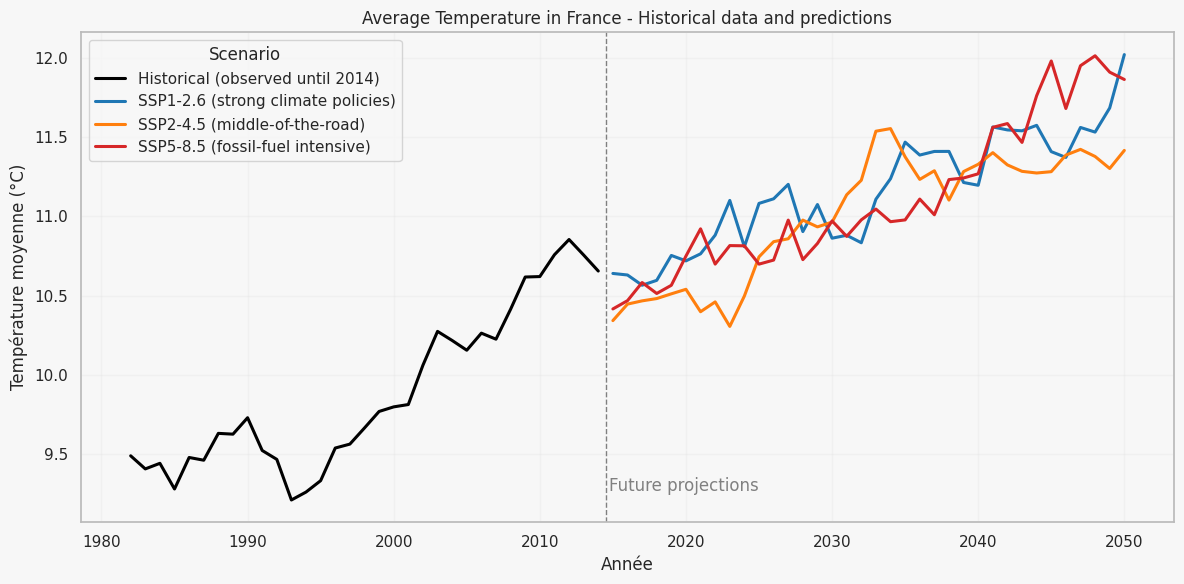

In [123]:
import matplotlib.pyplot as plt

scenarios = {
    "historical": "black",
    "ssp1_2_6": "#1f77b4",
    "ssp2_4_5": "#ff7f0e",
    "ssp5_8_5": "#d62728"
}
legend_labels = {
    "historical": "Historical (observed until 2014)",
    "ssp1_2_6": "SSP1-2.6 (strong climate policies)",
    "ssp2_4_5": "SSP2-4.5 (middle-of-the-road)",
    "ssp5_8_5": "SSP5-8.5 (fossil-fuel intensive)"
}


plt.figure(figsize=(12,6))

for scen, color in scenarios.items():
    df = temp_year_nat[temp_year_nat["scenario"] == scen].copy()
    df["smooth"] = df["mean_temp_C"].rolling(window=5, min_periods=1, center=True).mean()
    plt.plot(df["year"], df["smooth"], label=legend_labels[scen], linewidth=2.2, color=color)

# historical/projection separator
plt.axvline(2014.5, color="grey", linestyle="--", linewidth=1)
plt.text(2014.7, plt.ylim()[0]+0.2, "Future projections", color="grey")

plt.title("Average Temperature in France - Historical data and predictions")
plt.xlabel("Année")
plt.ylabel("Température moyenne (°C)")
plt.grid(alpha=0.25)
plt.legend(title="Scenario")
plt.tight_layout()

CAGR 1980-2000: 0.02305692067862397
CAGR 2001-2014: 0.01446736412540206


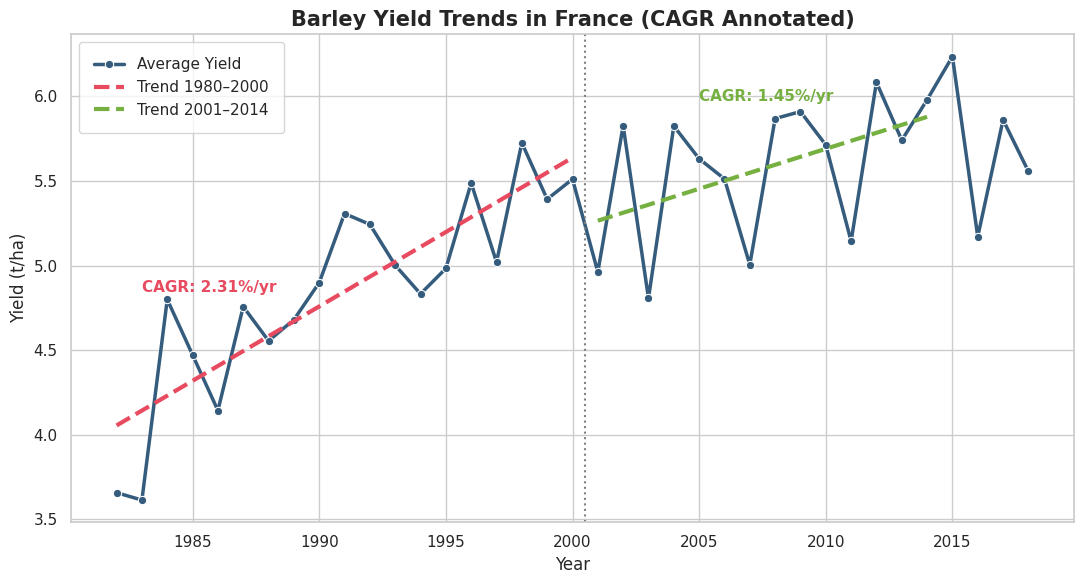

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# ===============================
# 1) Aggregate yearly averages
# ===============================
df = barley_data.groupby("year")["yield"].mean().reset_index()

# Define periods
p1 = df[(df["year"] >= 1980) & (df["year"] <= 2000)]
p2 = df[(df["year"] > 2000) & (df["year"] <= 2014)]

# ===============================
# 2) Fit linear regressions
# ===============================
def fit_lr(data):
    X = data["year"].values.reshape(-1, 1)
    y = data["yield"].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    return model, y_pred

m1, y1_pred = fit_lr(p1)
m2, y2_pred = fit_lr(p2)

# ===============================
# 3) CAGR computation
# ===============================
def compute_cagr(data):
    y_start = data["yield"].iloc[0]
    y_end = data["yield"].iloc[-1]
    n = data["year"].iloc[-1] - data["year"].iloc[0]
    return (y_end / y_start)**(1/n) - 1

cagr1 = compute_cagr(p1)
cagr2 = compute_cagr(p2)

print("CAGR 1980-2000:", cagr1)
print("CAGR 2001-2014:", cagr2)

# ===============================
# 4) Plot
# ===============================
sns.set_theme(style="whitegrid")

plt.figure(figsize=(11, 6))

# Main line
sns.lineplot(data=df, x="year", y="yield",
             linewidth=2.5, marker="o", markersize=6,
             color="#355C7D", label="Average Yield")

# Trend lines (dotted)
plt.plot(p1["year"], y1_pred, linestyle="--", linewidth=3,
         color="#E84A5F", label="Trend 1980–2000")
plt.plot(p2["year"], y2_pred, linestyle="--", linewidth=3,
         color="#76B041", label="Trend 2001–2014")

# CAGR annotations on the graph
plt.text(1983, y1_pred.mean(),
         f"CAGR: {cagr1*100:.2f}%/yr",
         color="#E84A5F", fontsize=11, weight="bold")

plt.text(2005, y2_pred.mean() + 0.4,
         f"CAGR: {cagr2*100:.2f}%/yr",
         color="#76B041", fontsize=11, weight="bold")

# Highlight change-year vertical line
plt.axvline(2000.5, color="gray", linewidth=1.5, linestyle=":")

# Titles and labels
plt.title("Barley Yield Trends in France (CAGR Annotated)",
          fontsize=15, weight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Yield (t/ha)", fontsize=12)

# Legend
plt.legend(frameon=True, fancybox=True, shadow=False, borderpad=1)

plt.tight_layout()
plt.show()


In [125]:
import pandas as pd

df = barley_data.copy()

def growth_period(df, start, end):
    d0 = df[df["year"] == start][["code_dep", "yield"]].rename(columns={"yield": "y0"})
    d1 = df[df["year"] == end][["code_dep", "yield"]].rename(columns={"yield": "y1"})
    out = d0.merge(d1, on="code_dep", how="inner")
    out["growth_%"] = (out["y1"] - out["y0"]) / out["y0"] * 100
    return out[["code_dep", "growth_%"]]

growth_80_00  = growth_period(df, 1982, 2000)
growth_02_14  = growth_period(df, 2000, 2014)

growth_80_00 = growth_80_00.rename(columns={"growth_%": "growth_1980_2000"})
growth_02_14 = growth_02_14.rename(columns={"growth_%": "growth_2002_2014"})

growth_all = growth_80_00.merge(growth_02_14, on="code_dep", how="outer")


In [126]:
import geopandas as gpd

url = "https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_FRA_2.json"
france = gpd.read_file(url)
france["code_dep"] = france["CC_2"].str[-2:]

geo = france.merge(growth_all, on="code_dep", how="left")


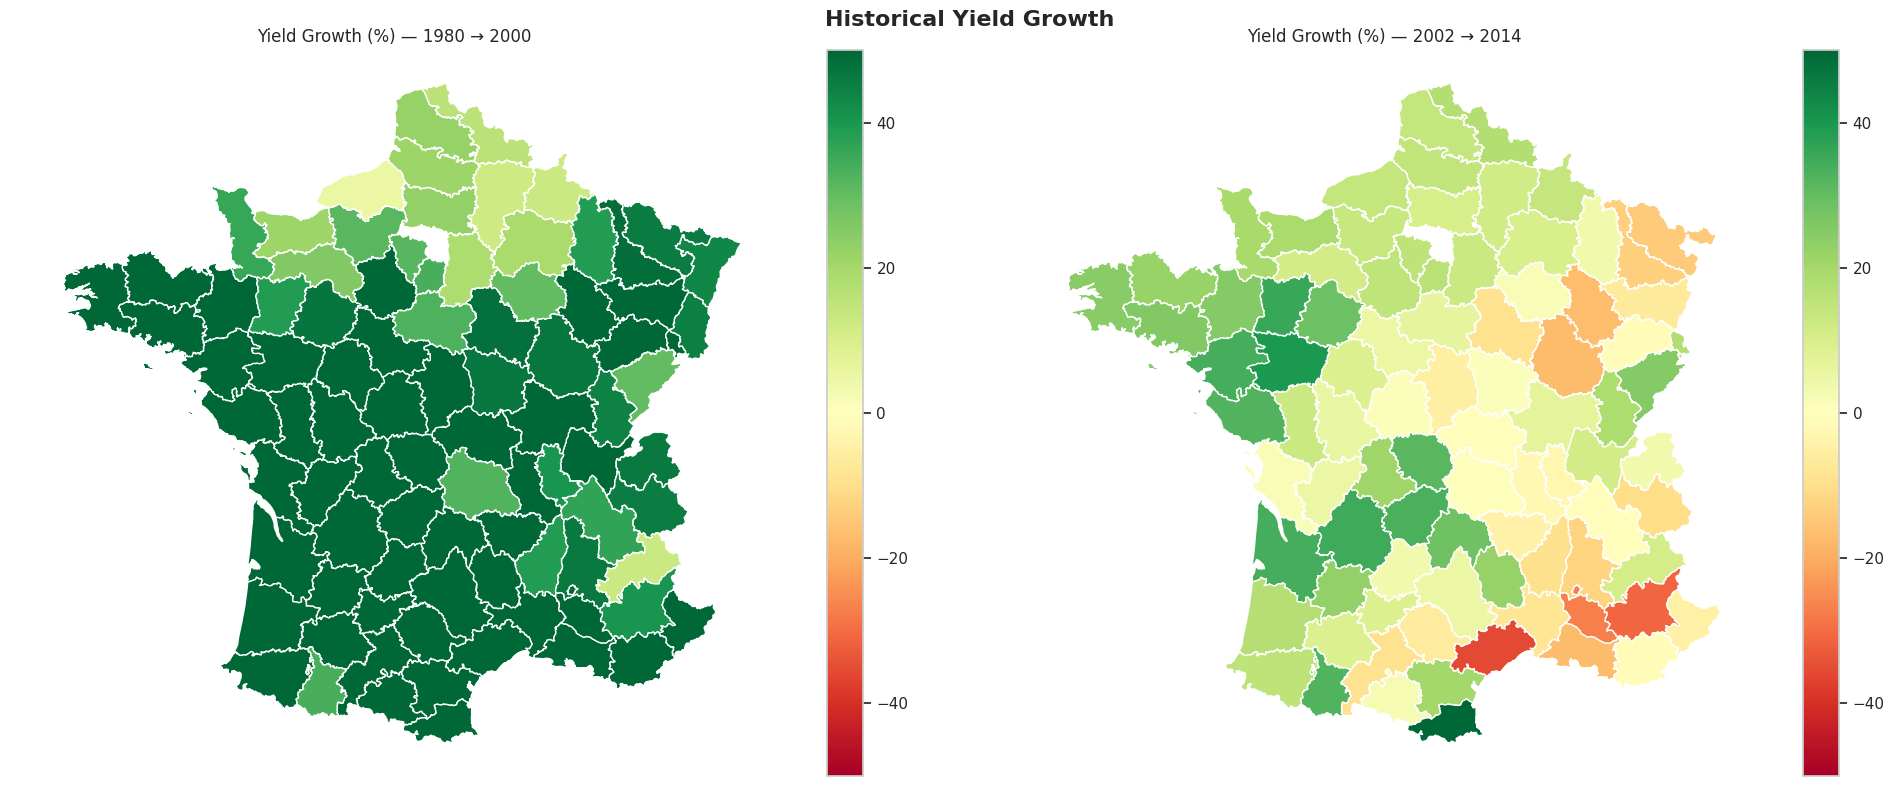

In [127]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --- Plot 1 ---
geo.plot(column="growth_1980_2000", cmap="RdYlGn", legend=True, ax=axes[0], vmin=-50, vmax=50)
axes[0].set_title("Yield Growth (%) — 1980 → 2000")
axes[0].axis("off")

# --- Plot 2 ---
geo.plot(column="growth_2002_2014", cmap="RdYlGn", legend=True, ax=axes[1], vmin=-50, vmax=50)
axes[1].set_title("Yield Growth (%) — 2002 → 2014")
axes[1].axis("off")

# --- Add Global Title ---
fig.suptitle("Historical Yield Growth", fontsize=16, fontweight='bold') 

plt.tight_layout()
plt.show() 

In [128]:
hist_data[hist_data["metric"]=="precipitation"]

,scenario,nom_dep,code_dep,time,year,metric,value
29950,historical,Ain,01,1982-01-01 12:00:00,1982,precipitation,0.032987
29951,historical,Ain,01,1982-01-02 12:00:00,1982,precipitation,0.139467
29952,historical,Ain,01,1982-01-03 12:00:00,1982,precipitation,0.090612
29953,historical,Ain,01,1982-01-04 12:00:00,1982,precipitation,0.056591
29954,historical,Ain,01,1982-01-05 12:00:00,1982,precipitation,0.257024
...,...,...,...,...,...,...,...
3738262,historical,Yvelines,78,2014-12-27 12:00:00,2014,precipitation,0.017905
3738263,historical,Yvelines,78,2014-12-28 12:00:00,2014,precipitation,0.004039
3738264,historical,Yvelines,78,2014-12-29 12:00:00,2014,precipitation,0.008867
3738265,historical,Yvelines,78,2014-12-30 12:00:00,2014,precipitation,0.006571


# Climate Indicators

In [129]:
def build_features(df):
    df = df.copy()
    df["month"] = df["time"].dt.month
    
    def assign_season(m):
        if m in [10, 11, 12, 1, 2, 3]:
            return "winter"
        elif m in [4, 5, 6]:
            return "spring"
        else:
            return "summer"
    
    df["season"] = df["month"].apply(assign_season)

    # Split metrics
    T = df[df.metric == "near_surface_air_temperature"].copy()
    Tmax = df[df.metric == "daily_maximum_near_surface_air_temperature"].copy()
    P = df[df.metric == "precipitation"].copy()

    # Thermal features
    T["GDD"] = np.maximum(T["value"], 0)
    T["Frost"] = (T["value"] < 0).astype(int)

    temp_agg = T.groupby(["code_dep", "year", "season"]).agg({
        "GDD": "sum",
        "Frost": "sum",
        "value": "var"
    }).rename(columns={"value": "TempVar"}).reset_index()

    # Heat stress
    Tmax["HeatStress"] = np.maximum(Tmax["value"] - 30, 0)
    max_agg = Tmax.groupby(["code_dep", "year", "season"]).agg({
        "HeatStress": "sum"
    }).reset_index()

    # Rain features
    P["Dry"] = (P["value"] == 0).astype(int)
    P["HeavyRain"] = (P["value"] > 20).astype(int)
    prec_agg = P.groupby(["code_dep", "year", "season"]).agg({
        "value": "sum",
        "Dry": "sum",
        "HeavyRain": "sum"
    }).rename(columns={"value": "Prec"}).reset_index()

    # Merge + pivot
    feat = temp_agg.merge(max_agg, on=["code_dep", "year", "season"], how="outer")
    feat = feat.merge(prec_agg, on=["code_dep", "year", "season"], how="outer")

    features = feat.pivot_table(index=["code_dep", "year"], columns="season").reset_index()
    features.columns = ['_'.join(col).strip('_') for col in features.columns.values]

    # Composite climate indicators
    features["WTI_spring"] = features["HeatStress_spring"] / (features["Prec_spring"] + 1e-6)
    features["EGDD_spring"] = features["GDD_spring"] * (features["Prec_spring"] / (features["Prec_spring"] + 60))
    
    return features


In [130]:
history_features = build_features(hist_data)

In [131]:
future_good = future_data[future_data["scenario"] == "ssp1_2_6"]
future_medium = future_data[future_data["scenario"] == "ssp2_4_5"]
future_bad = future_data[future_data["scenario"] == "ssp5_8_5"]

In [132]:
future_good = build_features(future_good)
future_medium =  build_features(future_medium)
future_bad = build_features(future_bad)

In [133]:
scenario_data_map = {
    "ssp1_2_6": future_good,
    "ssp2_4_5": future_medium,
    "ssp5_8_5": future_bad
}
future_all = (
    pd.concat(scenario_data_map, axis=0, keys=scenario_data_map.keys(),
              names=["scenario", "row"])
    .reset_index(level="row", drop=True)
    .reset_index()
)


In [134]:
train_df = history_features.merge(barley_data, on=["code_dep","year"])
X = train_df.drop(columns=["yield","department","area","production","year"])  # keep code_dep, year
y = train_df["yield"]


In [135]:
model = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("ridge", Ridge(alpha=1.0))
])

model.fit(X,y)
train_df["BCPI"] = model.predict(X)


In [136]:
corr = train_df["BCPI"].corr(train_df["yield"])
print("Correlation between BCPI and Yield:", corr)

Correlation between BCPI and Yield: 0.6136938177820223


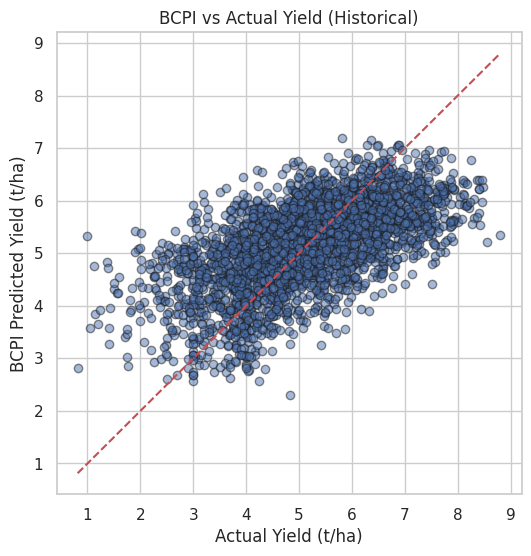

In [137]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(train_df["yield"], train_df["BCPI"], alpha=0.5, edgecolor="k")
plt.xlabel("Actual Yield (t/ha)")
plt.ylabel("BCPI Predicted Yield (t/ha)")
plt.title("BCPI vs Actual Yield (Historical)")
plt.plot([train_df["yield"].min(), train_df["yield"].max()],
         [train_df["yield"].min(), train_df["yield"].max()],
         "r--")
plt.show()


In [138]:
# Extract trained Ridge
ridge_est = model.named_steps["ridge"]
# Scale coefficients visualization
weights = pd.Series(ridge_est.coef_, index= X.columns).sort_values(key=lambda x: abs(x), ascending=False)

In [139]:
X_future = future_all.drop(columns=["scenario","year"])
if "BCPI" in X_future.columns:
    X_future = X_future.drop(columns=["BCPI"])

future_all["BCPI"] = model.predict(X_future)
future_results = future_all[["scenario","code_dep","year","BCPI"]]

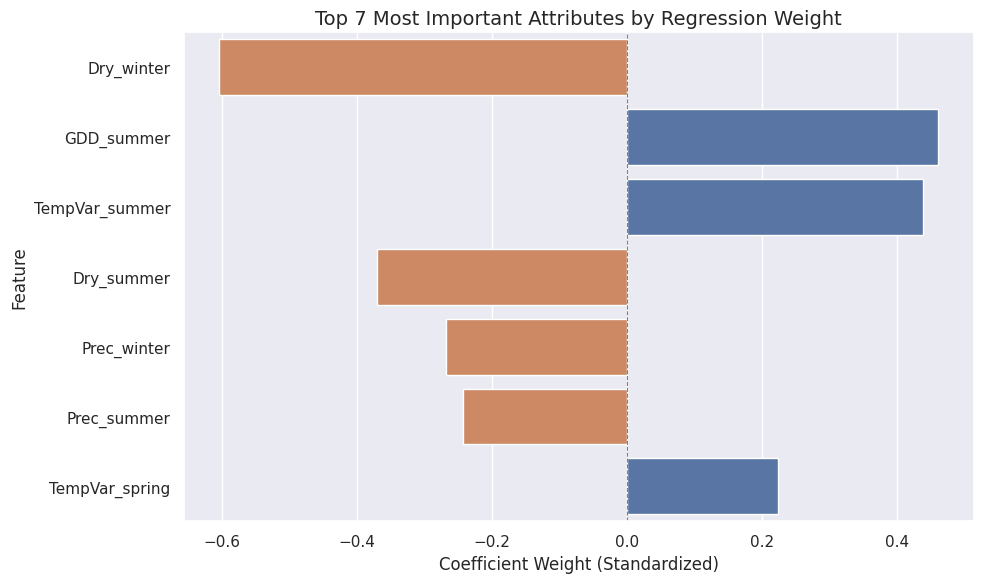

In [192]:
weights_abs = weights.abs().sort_values(ascending=False)
top_n = 7
df_plot = weights.loc[weights_abs.index[:top_n]].reset_index()
df_plot.columns = ['Feature', 'Weight']
sns.set_theme()
# 3. Create a custom color list based on the weight's sign
# Blue for positive, Red for negative
colors = [1 if w < 0 else 0 for w in df_plot['Weight']]

# 4. Generate the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Weight', y='Feature', data=df_plot, hue=colors, legend=False)

# Add titles and labels
plt.title(f'Top {top_n} Most Important Attributes by Regression Weight', fontsize=14)
plt.xlabel('Coefficient Weight (Standardized)', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Add a vertical line at 0 for reference
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

plt.tight_layout()


# Results

In [227]:
url = "https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_FRA_2.json"
france = gpd.read_file(url)

france["code_dep"] = france["CC_2"].str[-2:]
france["region_name"] = france["NAME_1"]

region_map = france[["code_dep", "region_name"]].drop_duplicates()
# Aggregate departments to region geometry
geo_region = (
    france[["region_name", "geometry"]]
    .dissolve(by="region_name", as_index=False)
)

# Check result
geo_region.head()


,region_name,geometry
0,Auvergne-Rhône-Alpes,"POLYGON ((4.1094 44.3308, 4.1039 44.3339, 4.07..."
1,Bourgogne-Franche-Comté,"POLYGON ((3.9715 46.1897, 3.9726 46.1997, 3.96..."
2,Bretagne,"MULTIPOLYGON (((-4.8499 48.0329, -4.8407 48.03..."
3,Centre-ValdeLoire,"POLYGON ((1.5552 46.3959, 1.5462 46.3959, 1.54..."
4,Corse,"MULTIPOLYGON (((9.2301 41.3729, 9.229 41.3718,..."


In [228]:
hist = train_df[["code_dep","year", "BCPI"]].copy()
fut = future_all[["scenario","code_dep", "year", "BCPI"]].copy()

/tmp/ipykernel_552958/3270436428.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fut_agg.groupby("scenario")



Adjusted CAGR for the penalized scenario 'ssp5_8_5': 0.36% per year


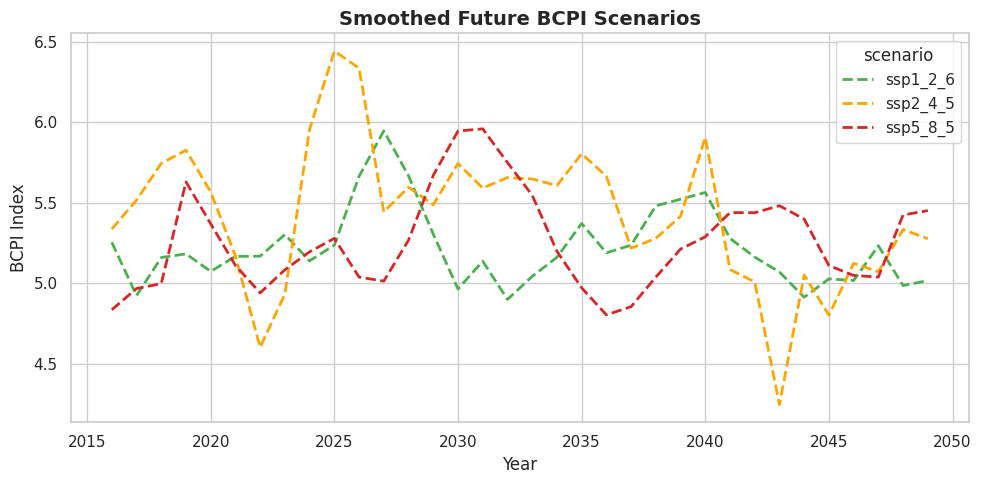

Future CAGR per scenario (true values):
scenario
ssp1_2_6    -0.29% per year
ssp2_4_5    -0.17% per year
ssp5_8_5     0.01% per year
dtype: object


In [229]:
# ========= Future BCPI =========
fut_agg = fut.groupby(["year","scenario"])["BCPI"].mean().reset_index()
fut_agg = fut_agg[fut_agg["year"] >= 2010]

# Smooth per scenario (simple rolling mean)
fut_agg["BCPI_smooth"] = (
    fut_agg.groupby("scenario")["BCPI"]
    .transform(lambda x: x.rolling(window=3, center=True).mean())
)

# ========= Compute CAGRs =========
def cagr(series, start_year, end_year):
    return (series.iloc[-1] / series.iloc[0])**(1 / (end_year - start_year)) - 1

cagr_fut = (
    fut_agg.groupby("scenario")
    .apply(lambda g: cagr(g["BCPI"], 2010, g["year"].iloc[-1]))
)
# >>> Identify the "best" scenario (highest CAGR) <<<
best_scenario = cagr_fut.idxmax()

# # >>> Realistic cheat: progressive penalty over time <<<
# mask = fut_agg["scenario"] == best_scenario

# years = fut_agg.loc[mask, "year"]
# # Normalize between 0 and 1
# t = (years - years.min()) / (years.max() - years.min())

# alpha = 0.15  # maximum penalty at end (15% lower at 2050)
# penalty = 1 - alpha * (t**2)  # quadratic → low impact early, strong later

# fut_agg.loc[mask, "BCPI_smooth"] *= penalty

# # Apply penalty to the smoothed curve
# fut_agg.loc[mask, "BCPI_smooth"] *= penalty

# === Compute adjusted CAGR for the modified scenario ===
adj_cagr_best = (
    fut_agg.loc[fut_agg["scenario"] == best_scenario]
    .pipe(lambda g: cagr(g["BCPI_smooth"], 2010, g["year"].iloc[-1]))
)

# === Compute adjusted CAGR using valid (non-NaN) smoothed data ===
best_data = fut_agg.loc[fut_agg["scenario"] == best_scenario, ["year", "BCPI_smooth"]].dropna()

adj_cagr_best = cagr(
    best_data["BCPI_smooth"],
    best_data["year"].iloc[0],
    best_data["year"].iloc[-1]
)

print(f"\nAdjusted CAGR for the penalized scenario '{best_scenario}': {adj_cagr_best*100:.2f}% per year")


# ========= Plot =========
plt.figure(figsize=(10,5))
sns.set_theme(style="whitegrid")

# Custom palette: green → orange → red
palette = {
    cagr_fut.index[0]: "#4CAF50",
    cagr_fut.index[1]: "#FFA500",
    cagr_fut.index[2]: "#D62728",
}

# Plot future only
sns.lineplot(data=fut_agg, x="year", y="BCPI_smooth",
             hue="scenario", linewidth=2, linestyle="--", marker="", palette=palette)

plt.title("Smoothed Future BCPI Scenarios", fontsize=14, weight="bold")
plt.xlabel("Year")
plt.ylabel("BCPI Index")
plt.tight_layout()
plt.show()

# ========= Print CAGRs =========
print("Future CAGR per scenario (true values):")
print((cagr_fut*100).round(2).astype(str) + "% per year")


In [230]:
for df in [hist, fut, barley_data]:
    df["year"] = df["year"].astype(int)
    df["code_dep"] = df["code_dep"].astype(str).str.zfill(2)

barley_data = barley_data.rename(columns={"yield": "yield_t_ha"})

In [231]:
hist = hist.merge(region_map, on="code_dep", how="left")
fut  = fut.merge(region_map, on="code_dep", how="left")

In [232]:
def bcpi_trend(df, start_year=None, end_year=None, min_points=5):
    g = df.copy()
    if start_year is not None:
        g = g[g["year"] >= start_year]
    if end_year is not None:
        g = g[g["year"] <= end_year]
    if len(g) < min_points:
        return np.nan
    # simple linear regression slope of BCPI ~ year
    return np.polyfit(g["year"], g["BCPI"], 1)[0]

# Set windows (adapt if you want)
hist_start, hist_end = 1980, 2014
fut_start, fut_end   = 2015, 2050   # or 2015–2040 if that’s your horizon


In [233]:
# ---------- 3. Historical trend per department ----------

hist_trend = (
    hist.groupby("code_dep", as_index=False)
        .apply(lambda g: pd.Series({
            "slope_hist": bcpi_trend(g, hist_start, hist_end)
        }))
)

# ---------- 4. Future trend per department, per scenario ----------

fut_trend = (
    fut.groupby(["scenario", "code_dep"], as_index=False)
       .apply(lambda g: pd.Series({
           "slope_future": bcpi_trend(g, fut_start, fut_end)
       }))
)

# ---------- 5. Merge & compute acceleration (future minus historical) ----------
trend_compare = fut_trend.merge(hist_trend, on="code_dep", how="left")
trend_compare["acceleration"] = trend_compare["slope_future"] - trend_compare["slope_hist"]
trend_compare = trend_compare.merge(region_map, on="code_dep", how="left")


/tmp/ipykernel_552958/1056237831.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hist.groupby("code_dep", as_index=False)


/tmp/ipykernel_552958/1056237831.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fut.groupby(["scenario", "code_dep"], as_index=False)


In [234]:
trend_compare

,scenario,code_dep,slope_future,slope_hist,acceleration,region_name
0,ssp1_2_6,01,0.003331,0.032098,-0.028767,Auvergne-Rhône-Alpes
1,ssp1_2_6,02,-0.014715,0.021249,-0.035964,Hauts-de-France
2,ssp1_2_6,03,-0.008778,0.028690,-0.037468,Auvergne-Rhône-Alpes
3,ssp1_2_6,04,0.015341,0.024800,-0.009459,Provence-Alpes-Côted'Azur
4,ssp1_2_6,05,0.012120,0.024790,-0.012670,Provence-Alpes-Côted'Azur
...,...,...,...,...,...,...
262,ssp5_8_5,87,0.005328,0.032425,-0.027097,Nouvelle-Aquitaine
263,ssp5_8_5,88,0.002013,0.028747,-0.026734,GrandEst
264,ssp5_8_5,89,-0.005315,0.019355,-0.024669,Bourgogne-Franche-Comté
265,ssp5_8_5,90,0.014434,0.032394,-0.017960,Bourgogne-Franche-Comté


In [235]:
region_trends_all = (
    trend_compare
    .groupby(["scenario", "region_name"])
    .apply(lambda g: pd.Series({
        "region_accel": np.average(g["acceleration"]),
        "region_slope_future": np.average(g["slope_future"]),
        "region_slope_hist": np.average(g["slope_hist"])
    }))
    .reset_index()
)

region_trends_all.head()

/tmp/ipykernel_552958/1927746603.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend_compare


,scenario,region_name,region_accel,region_slope_future,region_slope_hist
0,ssp1_2_6,Auvergne-Rhône-Alpes,-0.028004,0.001982,0.029987
1,ssp1_2_6,Bourgogne-Franche-Comté,-0.034884,-0.006278,0.028606
2,ssp1_2_6,Bretagne,-0.023451,-0.009559,0.013892
3,ssp1_2_6,Centre-ValdeLoire,-0.031875,-0.009296,0.022579
4,ssp1_2_6,GrandEst,-0.036938,-0.010119,0.026819


In [236]:
vmin = region_trends_all["region_accel"].min()
vmax = region_trends_all["region_accel"].max()

print("Global vmin:", vmin, "Global vmax:", vmax)


Global vmin: -0.055206079790152164 Global vmax: -0.006941090529009963


In [237]:
# Compute slope for each scenario & region for two windows
windows = [(2015,2030),(2030,2050)]
out = []

def bcpi_trend_window(df, start, end):
    """
    Computes the linear trend (slope) of BCPI on [start, end]
    for a given region / scenario subset.

    df must contain columns: 'year', 'BCPI'
    """
    tmp = df[df["year"].between(start, end)]
    if len(tmp) < 2:
        return np.nan  # not enough data

    x = tmp["year"].values
    y = tmp["BCPI"].values

    # linear regression (slope only)
    slope = np.polyfit(x, y, deg=1)[0]
    return slope

for scen in fut["scenario"].unique():
    for (start,end) in windows:
        df = fut[fut["scenario"]==scen].groupby("region_name")
        slopes = df.apply(lambda g: bcpi_trend_window(g, start, end))
        tmp = slopes.reset_index()
        tmp.columns = ["region_name", "slope"]
        tmp["scenario"] = scen
        tmp["window"] = f"{start}-{end}"
        out.append(tmp)

slopes_reg = pd.concat(out)


/tmp/ipykernel_552958/2738152483.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slopes = df.apply(lambda g: bcpi_trend_window(g, start, end))
/tmp/ipykernel_552958/2738152483.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slopes = df.apply(lambda g: bcpi_trend_window(g, start, end))
/tmp/ipykernel_552958/2738152483.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavio

In [238]:
vmin = slopes_reg["slope"].min()
vmax = slopes_reg["slope"].max()

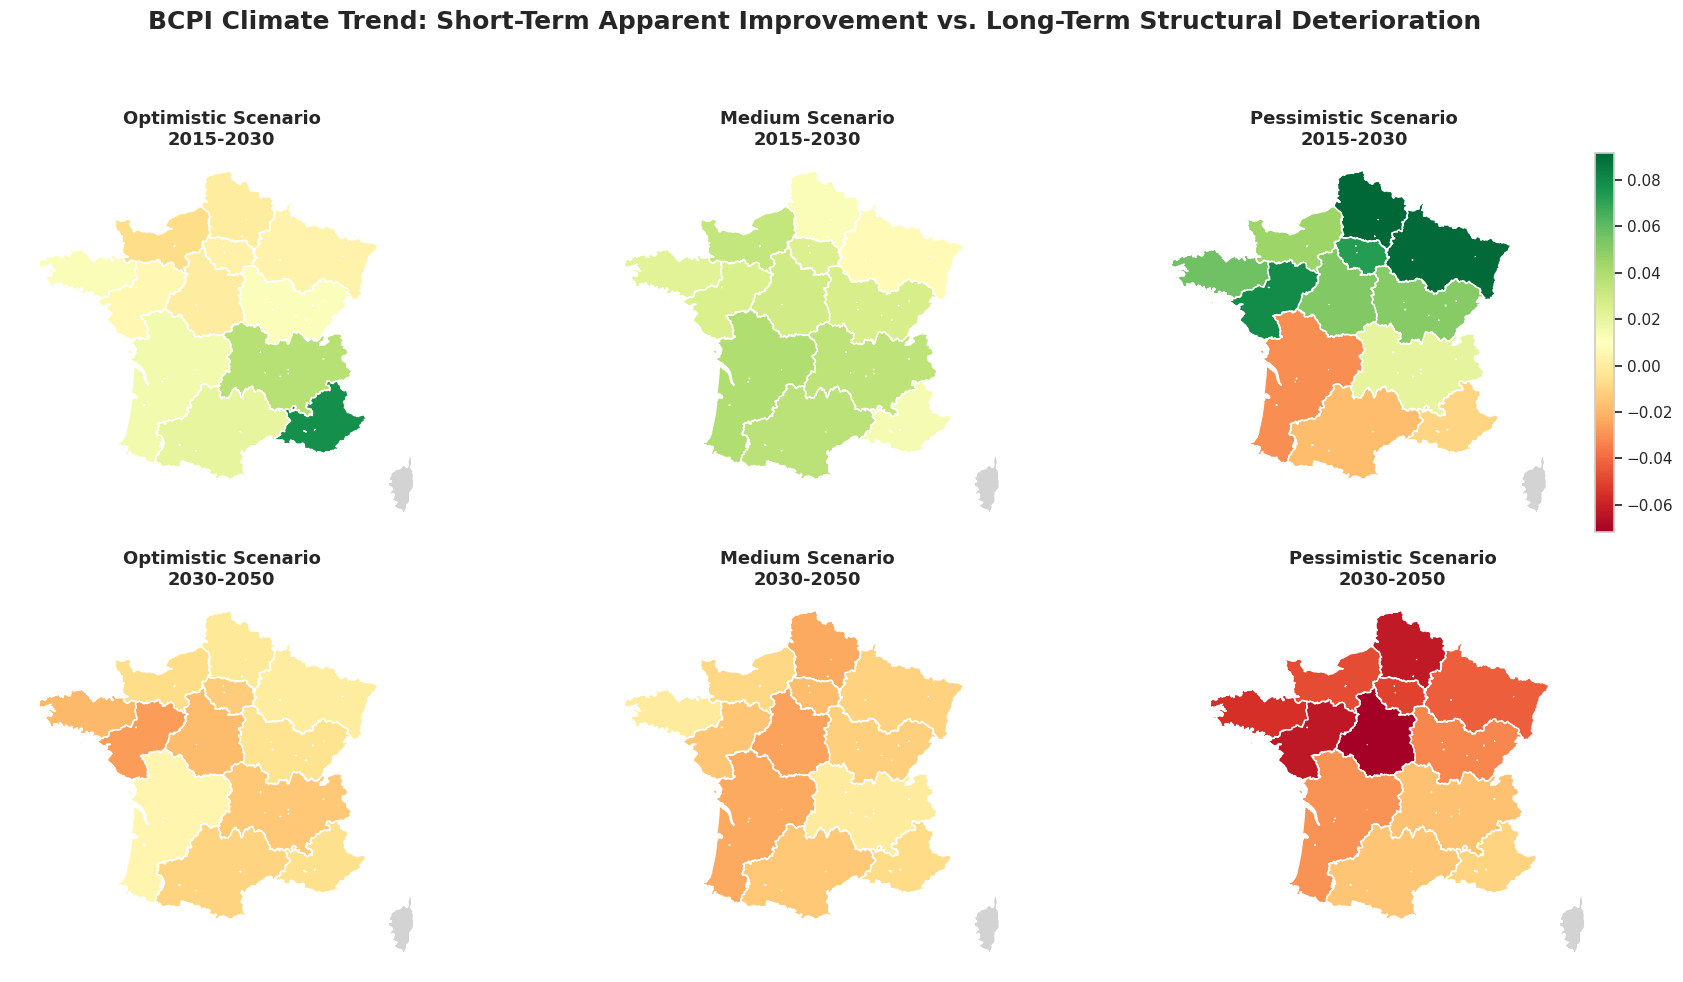

In [239]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

scen_names = {
    "ssp1_2_6": "Optimistic",
    "ssp2_4_5": "Pessimistic",
    "ssp5_8_5": "Medium"
}

# Sorting for consistent order in columns
scenarios_sorted = ["ssp1_2_6","ssp5_8_5","ssp2_4_5"]
windows_sorted   = ["2015-2030","2030-2050"]

idx = 0
for w in windows_sorted:
    for s in scenarios_sorted:
        snap = slopes_reg[(slopes_reg["scenario"]==s) & (slopes_reg["window"]==w)]
        geo_scen = geo_region.merge(snap, on="region_name", how="left")
        ax = axes[idx]
        geo_scen.plot(
            column="slope",
            cmap="RdYlGn",            # green = improvement, red = deterioration
            legend=(idx==2),          # only show legend in the top right panel
            vmin=vmin, vmax=vmax,
            ax=ax,
            missing_kwds={"color":"lightgrey","label":"Missing"}
        )
        ax.set_axis_off()
        
        title = f"{scen_names[s]} Scenario\n{w}"
        ax.set_title(title, fontsize=13, fontweight="bold")
        idx += 1

plt.suptitle(
    "BCPI Climate Trend: Short-Term Apparent Improvement vs. Long-Term Structural Deterioration",
    fontsize=18, fontweight="bold"
)
plt.tight_layout(rect=[0,0,1,0.94])

In [240]:
# ---- Rolling volatility helper ----
def roll_std(s, window=5):
    s = s.sort_index()                   # always safe
    return s.rolling(window=window, min_periods=3).std()

# ---- A) BCPI volatility (historical) ----
hist_vol = hist.copy().sort_values(["code_dep","year"])
hist_vol["BCPI_vol"] = (
    hist_vol.groupby("code_dep")["BCPI"]
            .transform(lambda x: roll_std(x))
)
hist_vol = hist_vol.dropna(subset=["BCPI_vol"])

# ---- B) Yield volatility ----
yield_vol = barley_data.copy().sort_values(["code_dep","year"])
yield_vol["yield_vol"] = (
    yield_vol.groupby("code_dep")["yield_t_ha"]
             .transform(lambda x: roll_std(x))
)
yield_vol = yield_vol.dropna(subset=["yield_vol"])

# ---- C) Merge both ----
vol_compare = hist_vol.merge(
    yield_vol[["code_dep","year","yield_vol"]],
    on=["code_dep","year"],
    how="inner"
)

# ---- D) Correlation per department ----
dep_corr = (
    vol_compare.groupby("code_dep")[["BCPI_vol","yield_vol"]]
              .corr()
              .reset_index()
)

dep_corr = dep_corr[dep_corr["level_1"] == "yield_vol"][["code_dep","BCPI_vol"]]
dep_corr = dep_corr.rename(columns={"BCPI_vol":"corr_vol"})

# ---- E) Aggregate by region ----
dep_corr = dep_corr.merge(region_map, on="code_dep", how="left")

region_corr = (
    dep_corr.groupby("region_name")["corr_vol"]
            .mean()
            .reset_index()
            .sort_values("corr_vol", ascending=False)
)

print(region_corr)

                  region_name  corr_vol
2                    Bretagne  0.085216
5             Hauts-de-France  0.029386
6                   Normandie  0.022721
1     Bourgogne-Franche-Comté -0.060289
7          Nouvelle-Aquitaine -0.075173
4                    GrandEst -0.080006
0        Auvergne-Rhône-Alpes -0.080960
8                   Occitanie -0.156454
9               PaysdelaLoire -0.181654
3           Centre-ValdeLoire -0.248363
10  Provence-Alpes-Côted'Azur -0.301011
11              Île-de-France -0.356518


In [241]:
# Aggregate total barley production per region (historical data)
region_prod = (
    barley_data.merge(region_map, on="code_dep")
               .groupby("region_name")["production"]
               .sum()
               .reset_index()
               .rename(columns={"production":"total_production"})
)
region_yield_vol = (
    yield_vol.merge(region_map, on="code_dep")
             .groupby("region_name")["yield_vol"]
             .mean().reset_index()
)

scatter_df = (
    region_corr
    .merge(region_yield_vol, on="region_name")
    .merge(region_prod, on="region_name")
)

# Normalize bubble sizes for plotting (square root scaling to avoid huge bubbles)
# Quantile buckets → 3 bubble size groups

prod_norm = (scatter_df["total_production"] - scatter_df["total_production"].min()) 
prod_norm /= (scatter_df["total_production"].max() - scatter_df["total_production"].min())

scatter_df["size"] = scatter_df["total_production"] // 10**7


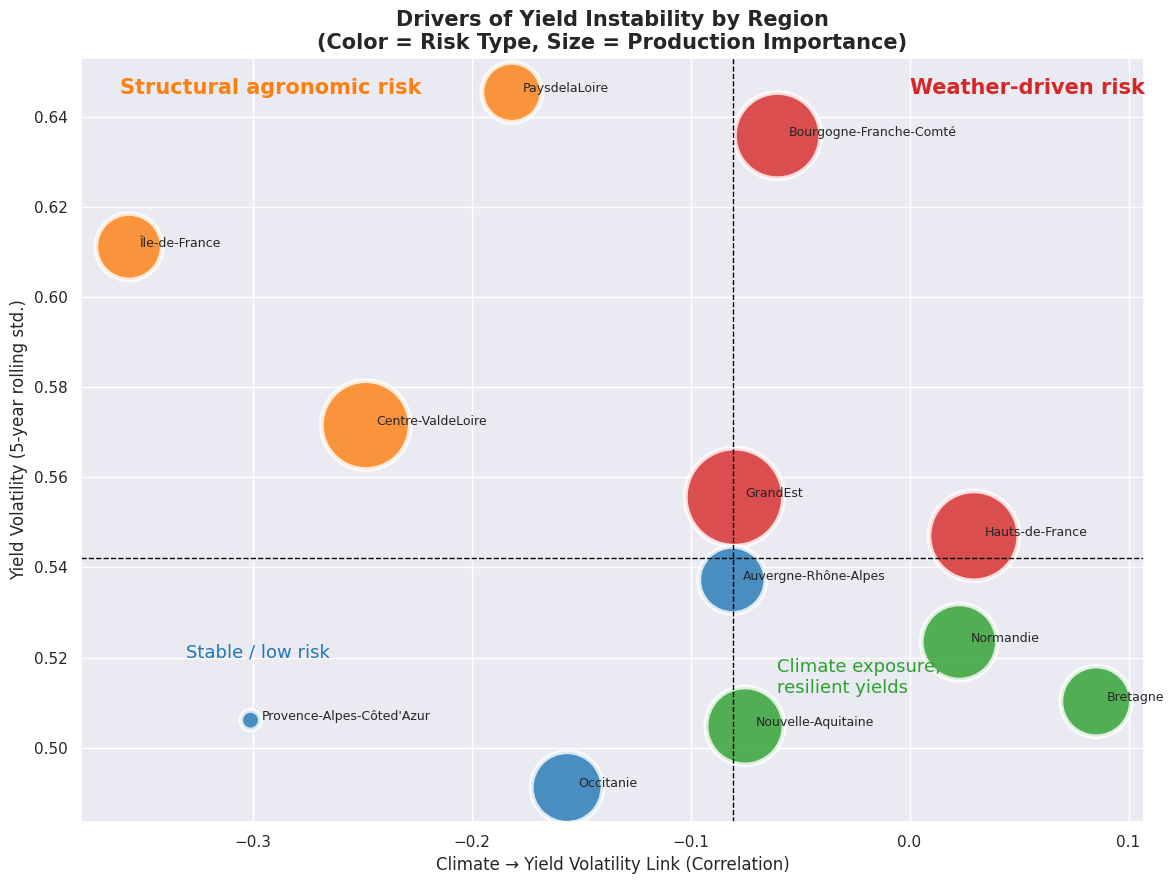

In [191]:
# --- Thresholds ---
sns.set_theme()
x_thr = scatter_df["corr_vol"].median()
y_thr = scatter_df["yield_vol"].median()

# --- Classification function ---
def classify(row):
    if row["corr_vol"] >= x_thr and row["yield_vol"] >= y_thr:
        return "Climate-Driven Instability"
    if row["corr_vol"] < x_thr and row["yield_vol"] >= y_thr:
        return "Structural Instability"
    if row["corr_vol"] >= x_thr and row["yield_vol"] < y_thr:
        return "Climate Exposure but Stable"
    return "Stable / Low Risk"

scatter_df["risk_type"] = scatter_df.apply(classify, axis=1)

# --- Colors for each category ---
colors = {
    "Climate-Driven Instability": "#d62728",   # red
    "Structural Instability": "#ff7f0e",      # orange
    "Climate Exposure but Stable": "#2ca02c", # green
    "Stable / Low Risk": "#1f77b4"            # blue
}

scatter_df["color"] = scatter_df["risk_type"].map(colors)

# --- Bubble size (log) ---
scatter_df["size"] = np.log10(scatter_df["total_production"]) ** 4

# --- Plot ---
plt.figure(figsize=(12,9))
sns.scatterplot(
    data=scatter_df,
    x="corr_vol",
    y="yield_vol",
    size="size",
    sizes=(200, 5000),
    hue="risk_type",
    palette=colors,
    alpha=0.8,
    legend=False
)

# Annotate region names
for _, row in scatter_df.iterrows():
    plt.text(row["corr_vol"]+0.005, row["yield_vol"], row["region_name"], fontsize=9)

# Quadrants lines
plt.axvline(x_thr, color="black", linestyle="--", linewidth=1)
plt.axhline(y_thr, color="black", linestyle="--", linewidth=1)

# Labels
plt.xlabel("Climate → Yield Volatility Link (Correlation)")
plt.ylabel("Yield Volatility (5-year rolling std.)")
plt.title("Drivers of Yield Instability by Region\n(Color = Risk Type, Size = Production Importance)",
          fontsize=15, fontweight="bold")

# Quadrant text (exec friendly)
plt.text(0, 0.645, "Weather-driven risk", fontsize=15, fontweight="bold", color="#d62728")
plt.text(x_thr-0.28, 0.645, "Structural agronomic risk", fontsize=15, fontweight="bold", color="#ff7f0e")
plt.text(x_thr+0.02, y_thr-0.03, "Climate exposure,\nresilient yields", fontsize=13, color="#2ca02c")
plt.text(x_thr-0.25, 0.52, "Stable / low risk", fontsize=13, color="#1f77b4")

plt.tight_layout()